Processing Alaska (RGI2000-v7.0-G-01-13271)...
  - Map saved: RGI2000-v7.0-G-01-13271_map.png


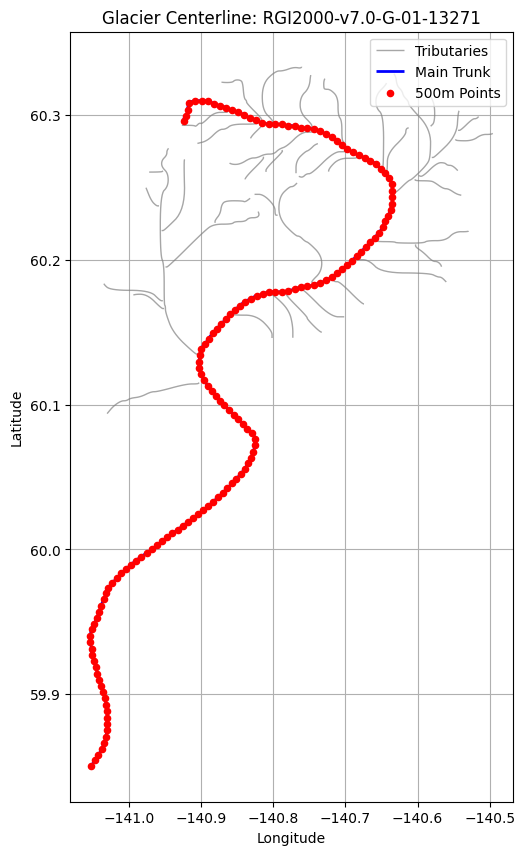


Success! Coordinates saved to 'glacier_centerline_points_500m.csv'


In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP: Define the glaciers and their corresponding Shapefiles
# You must have the .shp, .shx, and .dbf files in the same folder.
config = [
    {
        "region_name": "Alaska",
        "glacier_id": "RGI2000-v7.0-G-01-13271",
        "file_path": "RGI2000-v7.0-L-01_alaska/RGI2000-v7.0-L-01_alaska.shp",
        "proj_epsg": 3338  # Alaska Albers Equal Area (good for metric distance)
    }
    # ,
    # {
    #     "region_name": "Central Asia",
    #     "glacier_id": "RGI2000-v7.0-G-13-05693",
    #     "file_path": "RGI2000-v7.0-L-13_central_asia.shp", # MISSING IN UPLOAD
    #     "proj_epsg": 102027 # Asia North Albers (or use UTM)
    # }
]

all_points_data = []

for item in config:
    print(f"Processing {item['region_name']} ({item['glacier_id']})...")
    
    try:
        # Load the shapefile
        gdf = gpd.read_file(item['file_path'])
        
        # Filter for the specific glacier
        glacier_gdf = gdf[gdf['rgi_g_id'] == item['glacier_id']].copy()
        
        if glacier_gdf.empty:
            print(f"  - Glacier ID {item['glacier_id']} not found in file.")
            continue
            
        # Select the Main Trunk (is_main = 1) for the 500m sampling
        # We plot ALL lines, but only sample points along the main flowline.
        main_trunk = glacier_gdf[glacier_gdf['is_main'] == 1].copy()
        
        # Reproject to metric CRS to calculate 500m spacing accurately
        main_trunk_proj = main_trunk.to_crs(epsg=item['proj_epsg'])
        
        # Generate points every 500m
        points_list = []
        for idx, row in main_trunk_proj.iterrows():
            line = row['geometry']
            # Create distances: 0, 500, 1000, ... up to line length
            distances = np.arange(0, line.length, 500)
            
            for dist in distances:
                pt_proj = line.interpolate(dist)
                points_list.append(pt_proj)
                
        # Convert points back to WGS84 (Lat/Lon) for export
        gdf_points_proj = gpd.GeoDataFrame(geometry=points_list, crs=item['proj_epsg'])
        gdf_points_wgs84 = gdf_points_proj.to_crs(epsg=4326)
        
        # Store for CSV
        for i, pt in enumerate(gdf_points_wgs84.geometry):
            all_points_data.append({
                "Region": item['region_name'],
                "Glacier_ID": item['glacier_id'],
                "Point_Index": i,
                "Longitude": pt.x,
                "Latitude": pt.y,
                "Distance_m": i * 500
            })
            
        # --- PLOTTING ---
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # 1. Plot all centerline segments (Tributaries) in Grey
        glacier_gdf.plot(ax=ax, color='grey', linewidth=1, alpha=0.7, label='Tributaries')
        
        # 2. Plot Main Trunk in Blue
        # (We use the WGS84 version for plotting to match the axis coords)
        main_trunk.plot(ax=ax, color='blue', linewidth=2, label='Main Trunk')
        
        # 3. Plot 500m Points in RED
        gdf_points_wgs84.plot(ax=ax, color='red', markersize=20, label='500m Points', zorder=5)
        
        ax.set_title(f"Glacier Centerline: {item['glacier_id']}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        ax.grid(True)
        
        # Save Plot
        filename = f"{item['glacier_id']}_map.png"
        plt.savefig(filename)
        print(f"  - Map saved: {filename}")
        plt.show()

    except Exception as e:
        print(f"  - Could not process file {item['file_path']}: {e}")

# Save all points to CSV
if all_points_data:
    df_out = pd.DataFrame(all_points_data)
    df_out.to_csv("glacier_centerline_points_500m.csv", index=False)
    print("\nSuccess! Coordinates saved to 'glacier_centerline_points_500m.csv'")
else:
    print("\nNo data extracted.")

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Point

# --- CONFIGURATION ---
# 1. Paths to your downloaded USGS DEM files (Update these!)
# The glacier likely spans across both tiles, so we load both.
dem_files = [
    "USGS_1_n60w141/USGS_1_n60w141.tif", 
    "USGS_1_n60w140/USGS_1_n60w140.tif"
]

# 2. Shapefile Path
shp_path = "RGI2000-v7.0-L-01_alaska.shp"
target_id = "RGI2000-v7.0-G-01-13271"

# 3. Elevation Threshold (The "Paper" Logic)
# Points BELOW this elevation are "Red" (Analysis/Ablation Zone).
# Points ABOVE are "Black" (Accumulation Zone).
# For this region (St. Elias), the ELA is roughly 1100m - 1200m.
ELEVATION_CUTOFF = 1150 

# --- HELPER FUNCTION: Get Elevation from List of DEMs ---
def get_elevation_from_dems(lon, lat, dem_path_list):
    """Checks multiple DEMs to find the elevation for a coordinate."""
    for path in dem_path_list:
        try:
            with rasterio.open(path) as src:
                # Check if point is inside this DEM's bounds
                if (src.bounds.left <= lon <= src.bounds.right and 
                    src.bounds.bottom <= lat <= src.bounds.top):
                    
                    # Sample the data
                    row, col = src.index(lon, lat)
                    data = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))
                    val = data[0][0]
                    
                    # Filter out "No Data" values (often -9999 or extremely low/high)
                    if val > -500 and val < 9000: 
                        return val
        except Exception as e:
            print(f"Skipping {path}: {e}")
            continue
    return None # Point not found in any provided DEM

# --- MAIN PROCESSING ---

# 1. Load and Filter Centerlines
print("Loading Shapefile...")
gdf = gpd.read_file(shp_path)
glacier = gdf[gdf['rgi_g_id'] == target_id].copy()

# 2. Project to Meters for 500m Spacing (Alaska Albers)
glacier_proj = glacier.to_crs(epsg=3338)

points_data = []

print("Generating 500m points and sampling elevation...")
for idx, row in glacier_proj.iterrows():
    line = row['geometry']
    segment_id = row['segment_id']
    
    # Generate points every 500m
    distances = np.arange(0, line.length, 500)
    
    for dist in distances:
        # Get point in meters (for distance)
        pt_proj = line.interpolate(dist)
        
        # Convert back to WGS84 (Lat/Lon) for DEM lookup
        pt_wgs84 = gpd.GeoSeries([pt_proj], crs=3338).to_crs(4326).iloc[0]
        
        # Sample Elevation
        elev = get_elevation_from_dems(pt_wgs84.x, pt_wgs84.y, dem_files)
        
        if elev is not None:
            # APPLY THE PAPER'S LOGIC
            # Red = Analysis (Lower Reaches), Black = Context (Upper Reaches)
            color = "Red" if elev < ELEVATION_CUTOFF else "Black"
            
            points_data.append({
                "lat": pt_wgs84.y,
                "lon": pt_wgs84.x,
                "elevation": elev,
                "color_class": color,
                "segment_id": segment_id
            })

# 3. Save Results
df = pd.DataFrame(points_data)
df.to_csv(f"{target_id}_classified_points.csv", index=False)
print(f"Saved {len(df)} points to CSV.")

# 4. Plotting (Replicating Paper Figure 3A)
fig, ax = plt.subplots(figsize=(10, 10))

# Separate Red and Black points
red_pts = df[df['color_class'] == 'Red']
black_pts = df[df['color_class'] == 'Black']

# Plot Black (Upper Reaches - Context)
ax.scatter(black_pts['lon'], black_pts['lat'], c='black', s=10, label='Upper Reaches (>1150m)', alpha=0.5)

# Plot Red (Lower Reaches - Analysis)
ax.scatter(red_pts['lon'], red_pts['lat'], c='red', s=20, label='Lower Reaches (<1150m)')

ax.set_title(f"Glacier {target_id} (Paper Replication)\nSeparation by Elevation Threshold: {ELEVATION_CUTOFF}m")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig("alaska_glacier_paper_replication.png")
plt.show()

ModuleNotFoundError: No module named 'rasterio'